# Clustering Time Series


# 1. Introduction
## 1. 1. What is clustering ?

Clustering is a type of unsupervised learning problem and the main idea is finding similarities between different data points and pair them under the same group in a way that those data points in the same group (cluster) are more like each other than to those in other groups. It is one of the main tasks of exploratory data mining and used in many fields such as bioinformatics, pattern recognition, image analysis, machine learning, etc.
    
## 1. 2. What are time series ?
    
Time series are a stream of data that are created by making measures of something such as sales, temperature, stocks, etc. in fixed frequency. They have to be indexed in time order and usually used in weather forecasting, econometrics, earthquake prediction, signal processing, etc.
    
![Time series example](https://upload.wikimedia.org/wikipedia/commons/7/77/Random-data-plus-trend-r2.png)

# 2. Analysis

## 2. 1. Let's check the data

First of all, let's read it from the input and put them in a list.

In [1]:
#
!pip install minisom
!pip install tslearn

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.6-py3-none-any.whl size=13083 sha256=0aef8d4338318644d5c6600877f80b8bdf9ceb8f654be11397bd3b601b8978bb
  Stored in directory: /root/.cache/pip/wheels/84/35/b8/48b06bd8cae7187916c28a29c6daa9e0ff610647a2dfa62b97
Successfully built minisom
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.9/387.9 kB 7.0 MB/s eta 0:00:00


In [2]:
#
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from IPython.display import Image, display

# Warning control
import warnings
warnings.filterwarnings('ignore')

In [3]:
#
precios_5y = pd.read_excel('precios_5y.xlsx')

precios_5y.head()

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AC.MX,2020-12-01,80.088813,82.370130,79.983648,81.998001,NaN,1060283
1,AC.MX,2020-12-02,81.965638,86.487828,81.407441,84.780884,NaN,1864111
2,AC.MX,2020-12-03,84.497719,84.829402,82.628982,84.344017,NaN,1233829
3,AC.MX,2020-12-04,84.554379,87.126929,82.968783,83.251930,NaN,1451388
4,AC.MX,2020-12-07,83.648301,85.525129,83.106288,84.424919,NaN,1093850


## 2. 2. Preprocessing


In [4]:
#
precios_5y['Ticker'].value_counts()

,count
Ticker,
AC.MX,1260
ALFAA.MX,1260
AGUA.MX,1260
ASURB.MX,1260
ARA.MX,1260
...,...
ACTINVRB.MX,952
SITES1A-1.MX,935
BAFARB.MX,890


In [5]:
#
ticker_counts_df = precios_5y['Ticker'].value_counts().reset_index()

ticker_counts_df.columns = ['Ticker', 'Count']

tickers_1260 = ticker_counts_df[ticker_counts_df['Count'] == 1260].reset_index(drop = True)

tickers_1260.shape

(55, 2)

In [6]:
#
tickers_sel = tickers_1260.Ticker.to_list()
len(tickers_sel)

55

In [7]:
#
precios_wide = precios_5y.pivot_table(index='Date', columns='Ticker', values='Close')

precios_wide.head()

Ticker,AC.MX,ACCELSAB.MX,ACTINVRB.MX,AERO.MX,AGUA.MX,AGUILASCPO.MX,ALFAA.MX,ALPEKA.MX,ALSEA.MX,ARA.MX,...,SIMECB.MX,SITES1A-1.MX,SORIANAB.MX,TLEVISACPO.MX,VALUEGFO.MX,VESTA.MX,VINTE.MX,VITROA.MX,VOLARA.MX,WALMEX.MX
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,81.998001,18.0,7.499413,NaN,19.003740,NaN,14.423355,17.688763,26.986250,2.340446,...,66.449997,NaN,16.208391,29.609810,163.000000,37.075535,24.556307,30.147488,22.100000,47.970409
2020-12-02,84.780884,18.0,7.499413,NaN,19.646788,NaN,14.649711,17.678942,27.015467,2.456228,...,66.209999,NaN,16.985706,29.208834,179.000000,37.814686,24.556307,31.424416,22.360001,48.718037
2020-12-03,84.344017,18.0,7.341529,NaN,19.722937,NaN,15.220123,17.453045,27.697186,2.572010,...,65.699997,NaN,16.736198,30.180084,187.899994,37.174091,24.556307,30.626337,22.430000,49.248344
2020-12-04,83.251930,18.0,7.341529,NaN,18.936052,NaN,15.229179,17.364651,27.862747,2.878004,...,65.139999,NaN,17.216021,29.992964,179.990005,37.243080,24.556307,30.566479,22.209999,47.500957
2020-12-07,84.424919,18.0,7.420470,NaN,18.487612,NaN,15.383101,17.482512,27.843267,2.886275,...,66.129997,NaN,17.273598,29.547434,179.990005,36.346249,24.556307,30.167439,23.459999,47.014122


In [8]:
#
precios_filtered_by_tickers = precios_wide[tickers_sel]

precios_filtered_by_tickers.head()

Ticker,AC.MX,ALFAA.MX,AGUA.MX,ASURB.MX,ARA.MX,ALSEA.MX,ALPEKA.MX,VOLARA.MX,PINFRA.MX,POCHTECB.MX,...,TLEVISACPO.MX,SORIANAB.MX,LABB.MX,LIVEPOLC-1.MX,MEGACPO.MX,MFRISCOA-1.MX,OMAB.MX,NEMAKA.MX,ORBIA.MX,PE&OLES.MX
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,81.998001,14.423355,19.003740,234.382065,2.340446,26.986250,17.688763,22.100000,135.001297,5.90,...,29.609810,16.208391,15.298789,59.300961,55.970215,2.009705,95.664413,6.755221,39.438290,315.342743
2020-12-02,84.780884,14.649711,19.646788,234.881897,2.456228,27.015467,17.678942,22.360001,140.923370,6.03,...,29.208834,16.985706,15.523301,61.014755,57.431705,2.004693,96.228760,6.725243,39.632896,335.983124
2020-12-03,84.344017,15.220123,19.722937,233.041565,2.572010,27.697186,17.453045,22.430000,140.915054,6.00,...,30.180084,16.736198,15.819971,63.218220,55.924557,1.994670,94.854065,6.905115,40.476135,350.286469
2020-12-04,83.251930,15.229179,18.936052,229.179123,2.878004,27.862747,17.364651,22.209999,145.672653,6.13,...,29.992964,17.216021,15.667629,65.054436,56.320370,1.964600,92.177017,6.895123,39.660686,334.253937
2020-12-07,84.424919,15.383101,18.487612,228.315735,2.886275,27.843267,17.482512,23.459999,143.601593,5.92,...,29.547434,17.273598,15.819971,65.386703,56.274693,1.944553,89.456558,6.755221,39.280762,339.111664


In [9]:
#
num_series_to_plot = 9

# Ensure there are enough series to plot
if len(precios_filtered_by_tickers.columns) < num_series_to_plot:
    num_series_to_plot = len(precios_filtered_by_tickers.columns)

# Randomly select 9 tickers
selected_tickers = np.random.choice(precios_filtered_by_tickers.columns, num_series_to_plot, replace=False)

selected_tickers

array(['MFRISCOA-1.MX', 'GAPB.MX', 'GMEXICOB.MX', 'OMAB.MX', 'CIEB.MX',
       'MEGACPO.MX', 'KIMBERA.MX', 'BIMBOA.MX', 'POCHTECB.MX'],
      dtype=object)

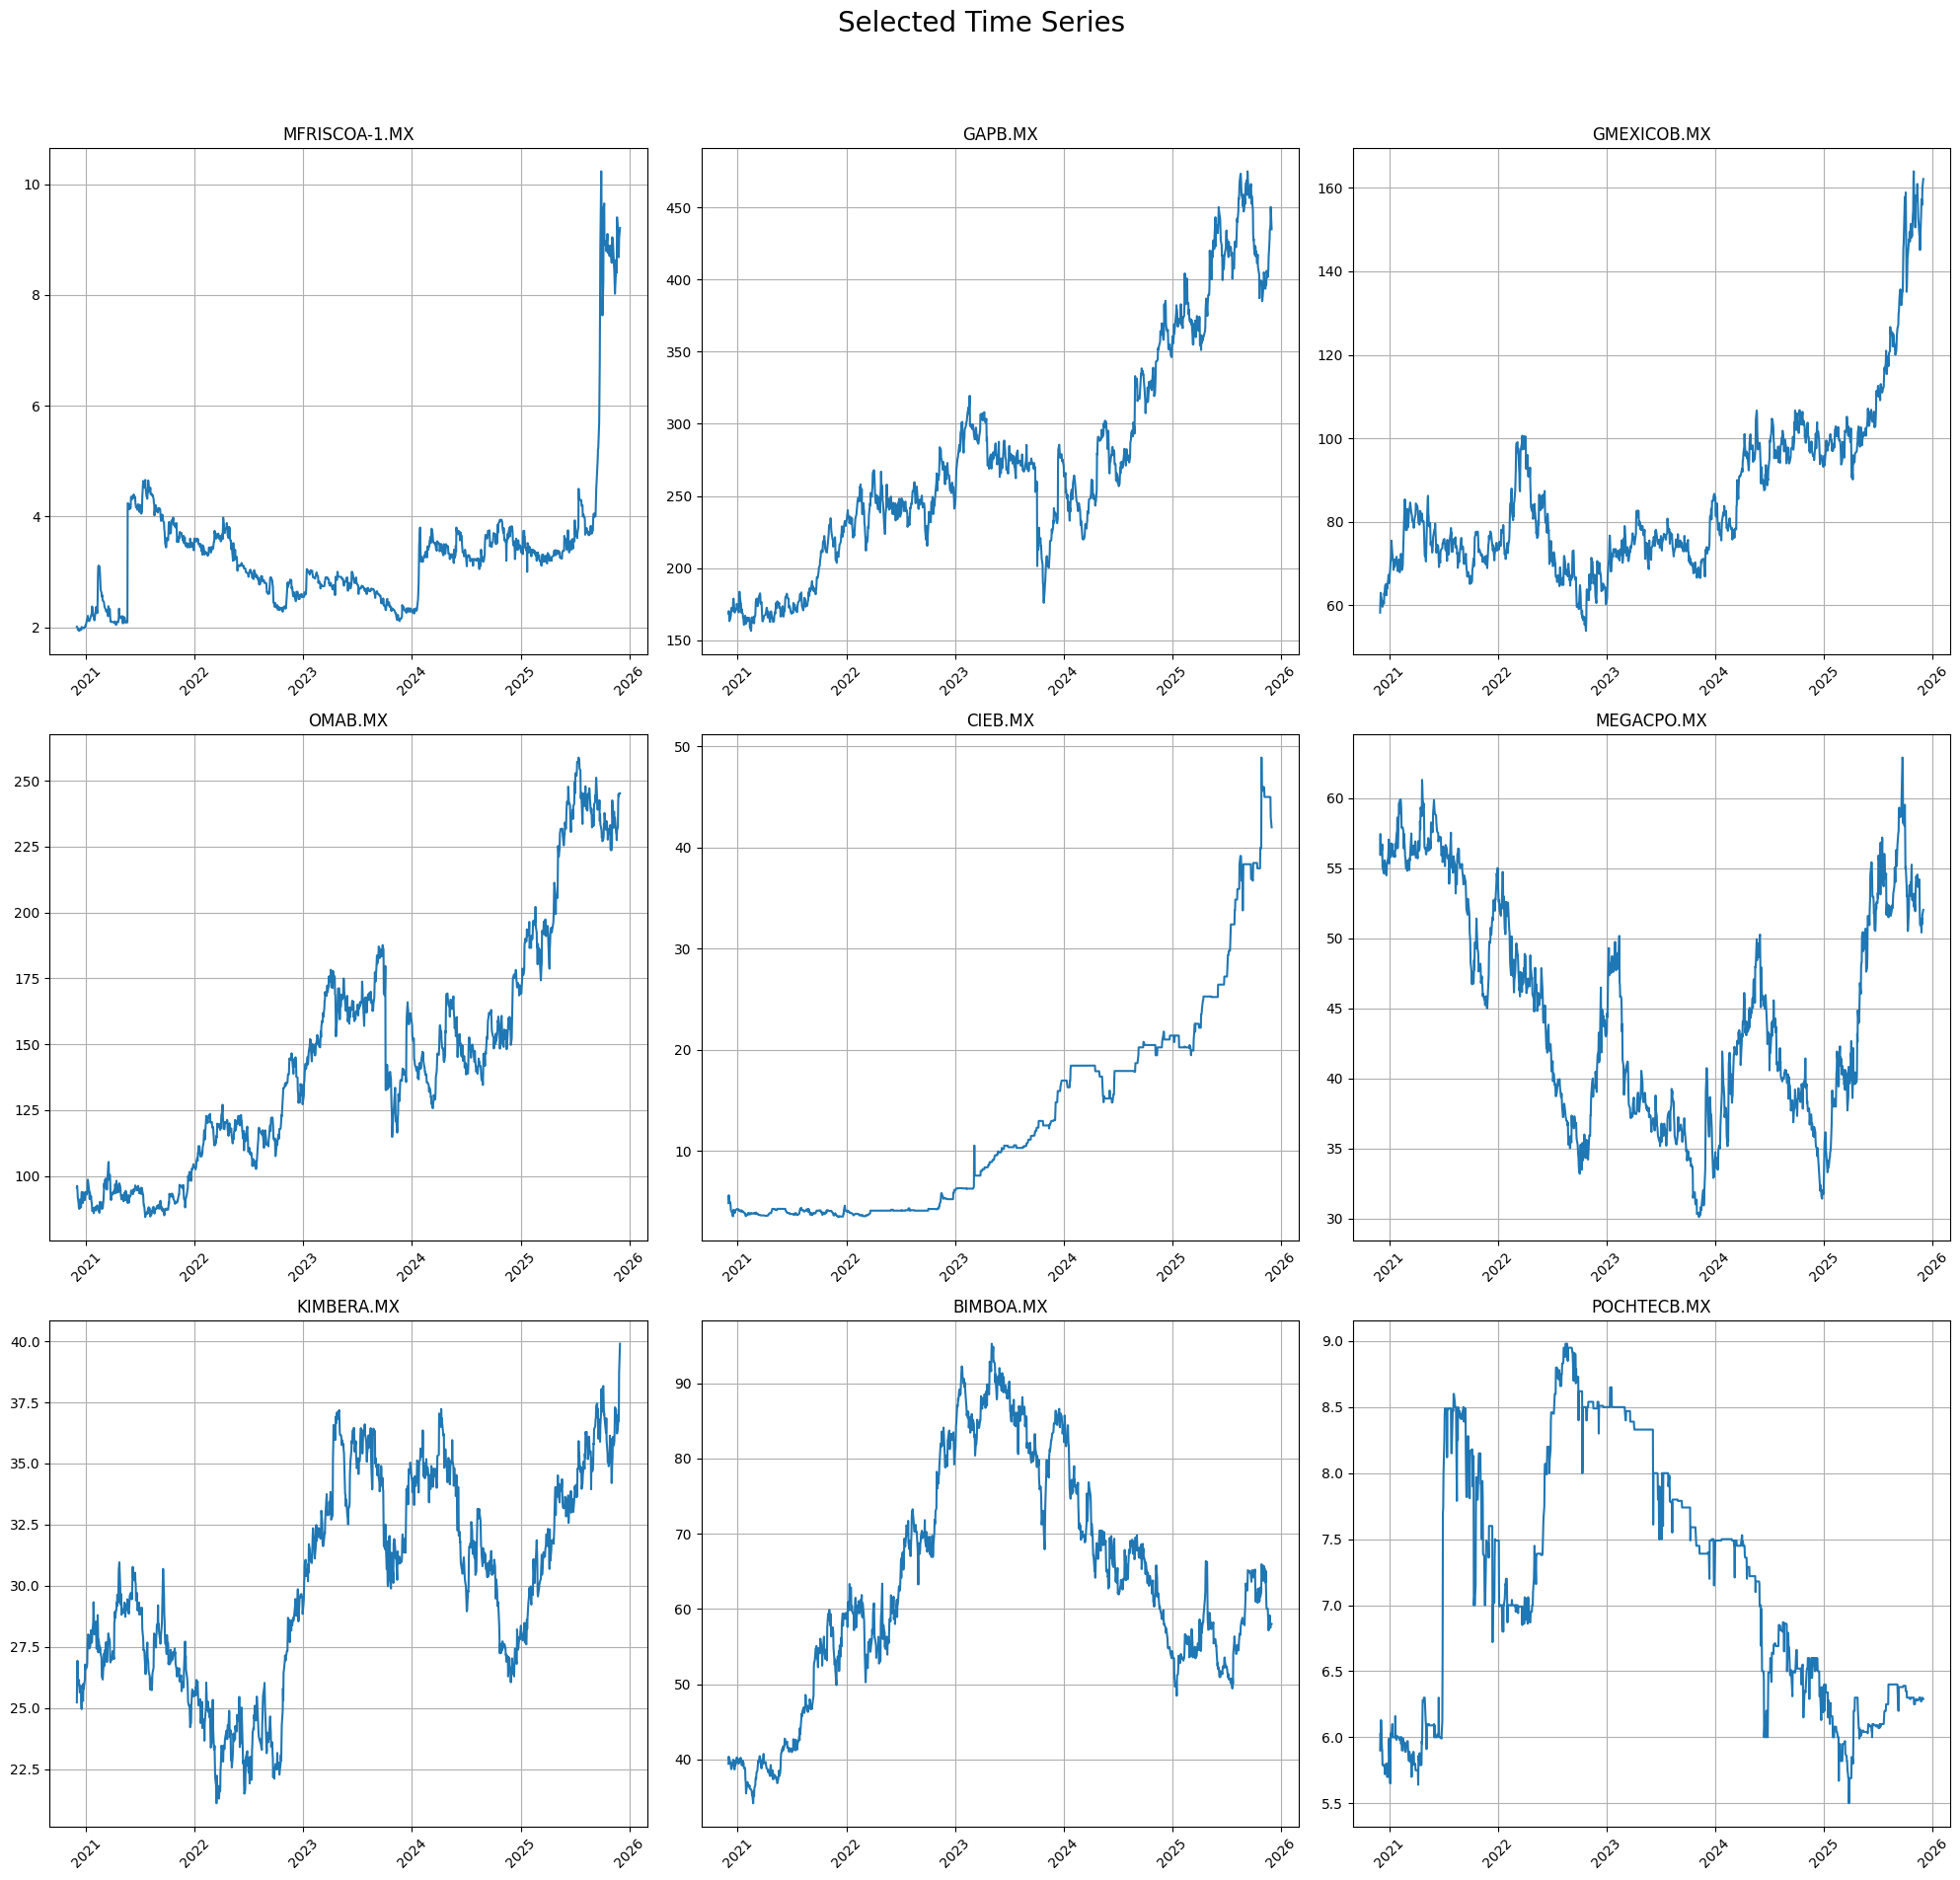

In [10]:
# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle('Selected Time Series', fontsize=20)

# Flatten the axes array for easy iteration
axs = axs.flatten()

for i, ticker in enumerate(selected_tickers):
    axs[i].plot(precios_filtered_by_tickers[ticker])
    axs[i].set_title(ticker)
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(True)

# Hide any unused subplots if less than 9 series were plotted
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

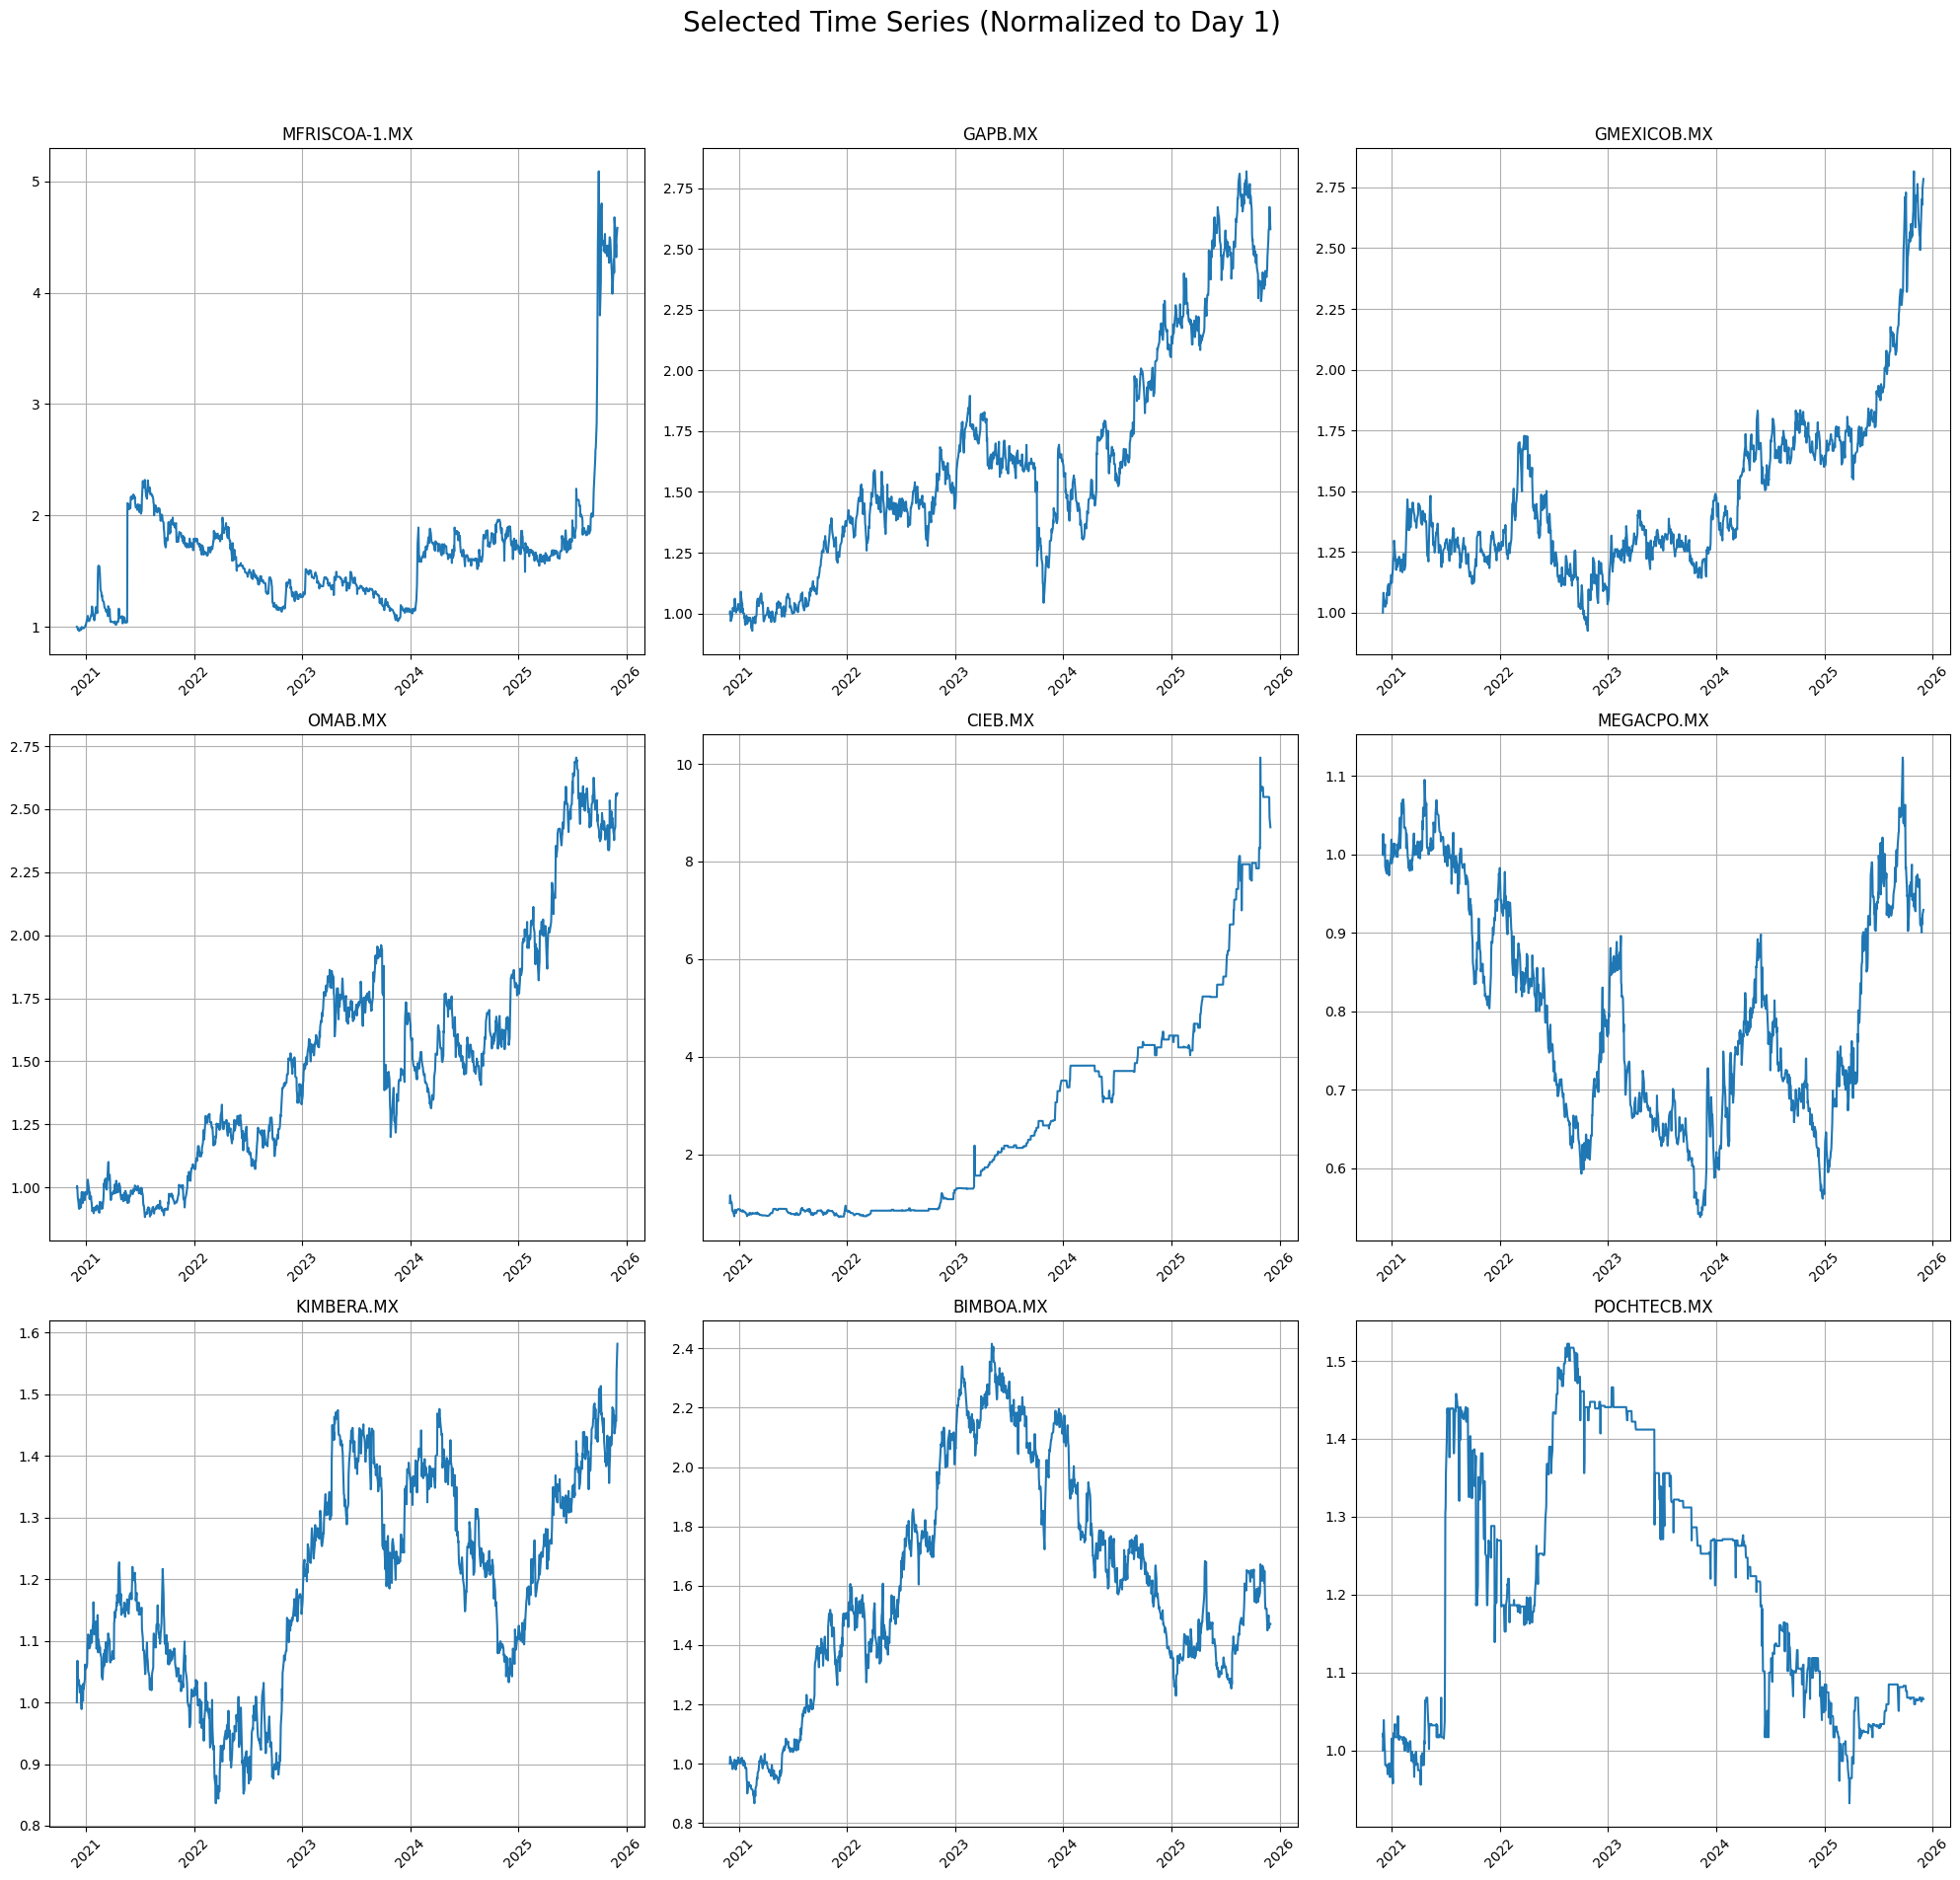

In [11]:
# Create a 3x3 grid of subplots for normalized series
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle('Selected Time Series (Normalized to Day 1)', fontsize=20)

# Flatten the axes array for easy iteration
axs = axs.flatten()

for i, ticker in enumerate(selected_tickers):
    # Get the series
    series = precios_filtered_by_tickers[ticker]
    # Normalize the series by its first value
    normalized_series = series / series.iloc[0]
    axs[i].plot(normalized_series)
    axs[i].set_title(ticker)
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(True)

# Hide any unused subplots if less than 9 series were plotted
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 3. Clustering


In [12]:
#
# Intenta importar el módulo que te compartí

from time_series_clustering_class import (
    extract_feature_matrix, cluster_feature_kmeans,
    pairwise_dtw_matrix, cluster_dtw_hierarchical, cluster_dtw_spectral,
    plot_feature_space_scatter, plot_series_by_cluster, plot_medoids, plot_dendrogram,
    distance_to_affinity
)

RANDOM_STATE = 0

In [13]:
# === UTILS: construir matrices alineadas (índice de fechas compartido) ===
def build_matrix_from_mapping(mapping, tickers, how="inner", normalize="first"):
    """
    mapping: dict[ticker -> pd.Series] o DataFrame con columnas=tickers
    devuelve: df (index=fecha, columns=tickers) + numpy array (n_series, T)
    normalize:
      - "first": divide por el primer valor de cada serie
      - "z": z-score por columna
      - None: sin normalizar
    """
    if hasattr(mapping, "columns"):  # DataFrame
        df = mapping[tickers].copy()
    else:
        cols = []
        for t in tickers:
            s = mapping[t].copy()
            s.name = t
            cols.append(s)
        df = pd.concat(cols, axis=1, join=how)

    # Orden temporal y limpieza básica
    df = df.sort_index().ffill().bfill()

    if normalize == "first":
        df = df / df.iloc[0]
    elif normalize == "z":
        df = (df - df.mean()) / (df.std(ddof=0).replace(0, np.nan))
        df = df.fillna(0)

    X = df.values.T  # filas=series, columnas=tiempo (congruente con el módulo)
    return df, X


In [14]:
#
#precios_filtered_by_tickers.shape
tickers = precios_filtered_by_tickers.columns

In [15]:
# === Construye dos vistas: normalización por primer día y z-score ===
df_first, X_first = build_matrix_from_mapping( precios_filtered_by_tickers, tickers, normalize="first" )
df_z,     X_z     = build_matrix_from_mapping( precios_filtered_by_tickers, tickers, normalize="z" )

print(df_first.shape, X_first.shape, df_z.shape, X_z.shape)

(1260, 55) (55, 1260) (1260, 55) (55, 1260)


## 3.1 Clustering “feature-based” (K-Means)

In [16]:
# === Extracción de features y clustering en espacio de características ===
feats = extract_feature_matrix(X_z, p_ar=3, k_fft=5, n_segments_sax=12, sax_alpha=7)

feats.shape

(55, 23)

In [17]:
#
res_feat, Z2, _ = cluster_feature_kmeans(feats, n_clusters=3, random_state=RANDOM_STATE)

print(f"Silhouette (feature-based): {res_feat.silhouette:.3f}")

Silhouette (feature-based): 0.129


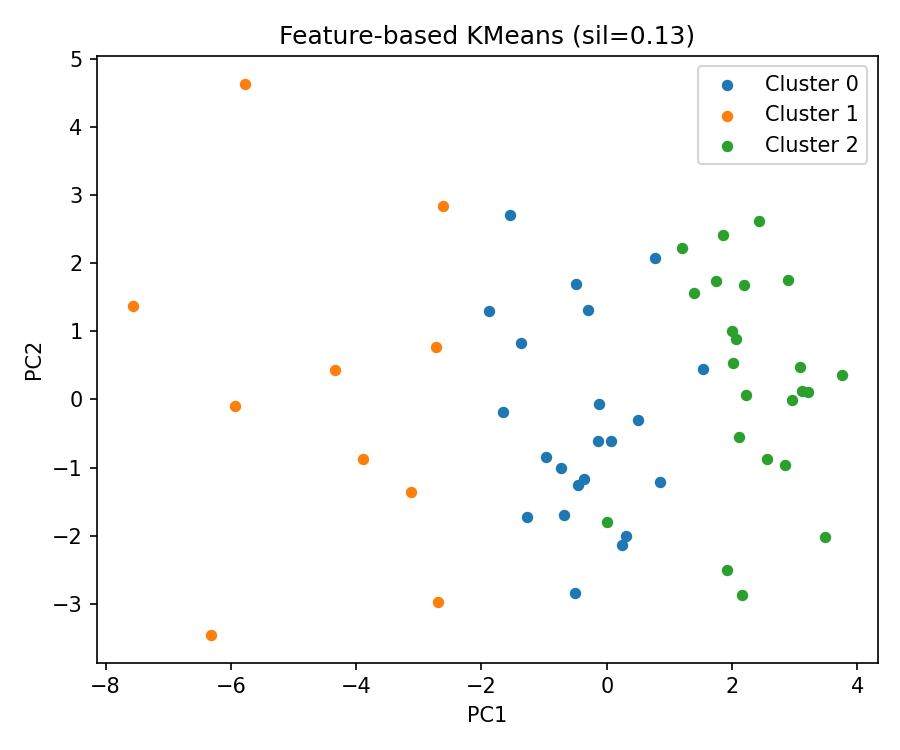

In [18]:
# === Visualizaciones  ===
# 2.1) Dispersión en PCA coloreada por cluster (espacio de features)
plot_feature_space_scatter(
    Z2, res_feat.labels,
    title=f"Feature-based KMeans (sil={res_feat.silhouette:.2f})",
    savepath="feature_space_scatter.png"
)
display(Image("feature_space_scatter.png"))

In [19]:
#
def plot_series_by_cluster(X, labels, n_per_cluster=5, savepath=None,
                           cmap="tab10", alpha=0.35, lw=1.2, show=False):
    """
    Dibuja hasta n_per_cluster series por clúster, usando un color fijo por clúster.
    Además superpone la media de cada clúster con una línea más gruesa.
    """
    t = np.arange(X.shape[1])
    clusters = np.unique(labels)
    # Si hay más de 10 clústeres, cambia automáticamente a 'tab20'
    cmap = plt.get_cmap("tab20" if (len(clusters) > 10 and cmap == "tab10") else cmap)
    colors = cmap(np.linspace(0, 1, len(clusters)))

    fig, ax = plt.subplots(figsize=(8, 6))
    for ci, c in enumerate(clusters):
        color = colors[ci]
        idx = np.where(labels == c)[0][:n_per_cluster]
        # Series individuales (semi-transparente)
        for i in idx:
            ax.plot(t, X[i], linewidth=lw, color=color, alpha=alpha)
        # Media del clúster (resaltada)
        if len(idx) > 0:
            mean_curve = X[idx].mean(axis=0)
            ax.plot(t, mean_curve, linewidth=2.6, color=color, alpha=0.95, label=f"Cluster {c}")

    ax.set_title("Muestras por clúster (color por clúster)")
    ax.set_xlabel("t"); ax.set_ylabel("nivel (normalizado)")
    ax.legend(loc="best", frameon=False)
    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=150)
    if show:
        plt.show()
    plt.close(fig)

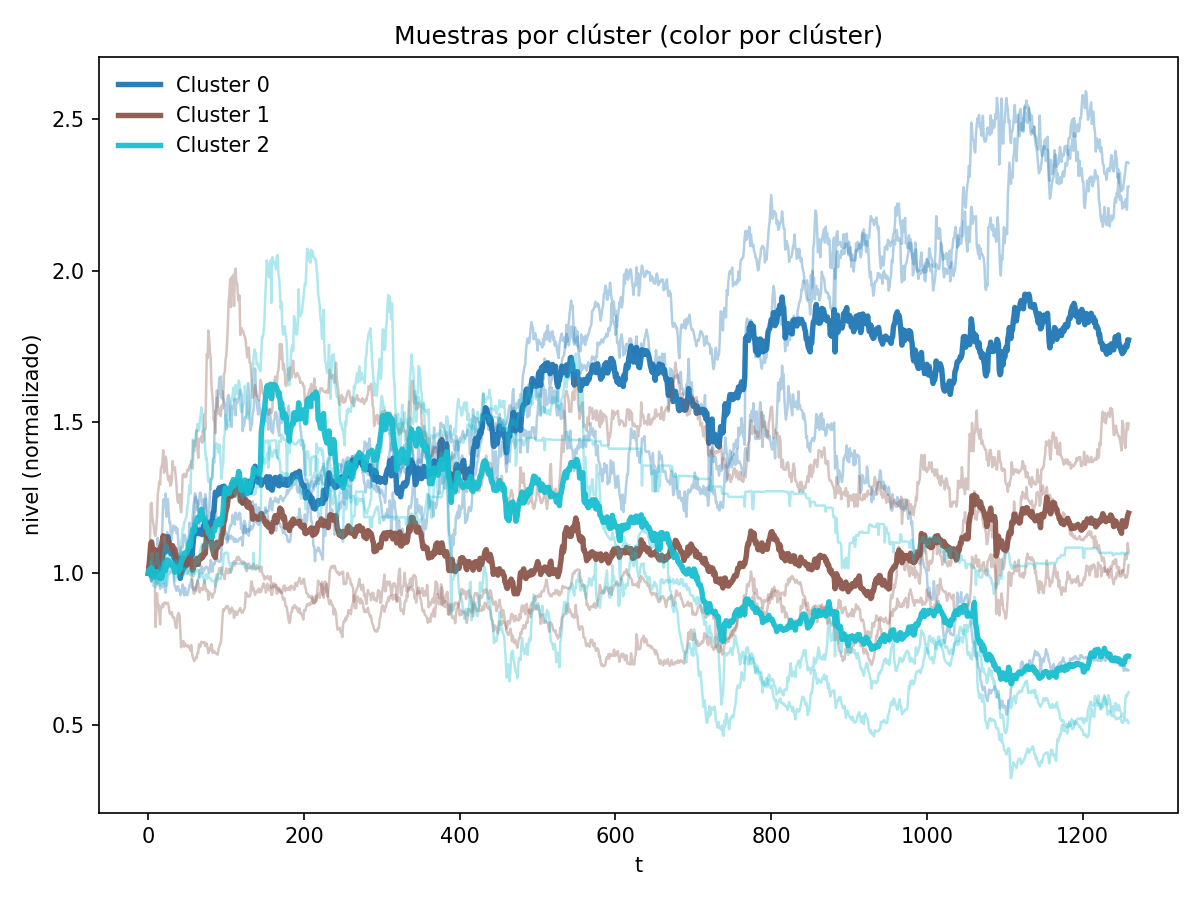

In [20]:
# 2.2) Muestras por cluster (sobre tus series normalizadas al día 1)
plot_series_by_cluster(
    X_first, res_feat.labels, n_per_cluster=3,
    savepath="series_by_cluster.png"
)
display(Image("series_by_cluster.png"))

In [21]:
# Etiquetas por serie (orden = tickers)
df_feat = pd.DataFrame({
    "ticker": tickers,
    "cluster_feature": res_feat.labels
})
df_feat.to_csv("labels_feature_kmeans.csv", index=False)
df_feat.head()

,ticker,cluster_feature
0,AC.MX,0
1,ALFAA.MX,1
2,AGUA.MX,0
3,ASURB.MX,0
4,ARA.MX,1
